In [45]:
import cv2 as cv
import numpy as np
from matplotlib.pylab import imshow
from skimage.filters import frangi
import math


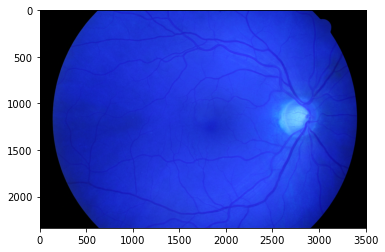

In [2]:
image = cv.imread('data/all/images/07_h.JPG')
imshow(image, cmap='gray')


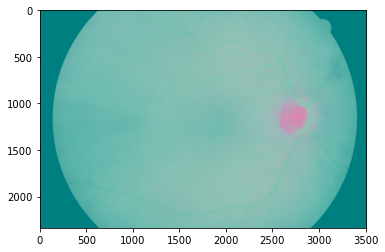

In [3]:
# convert to CIELAB color space and extract lightness
image_lab = cv.cvtColor(image, cv.COLOR_BGR2LAB)
imshow(image_lab)
l, a, b = cv.split(image_lab)


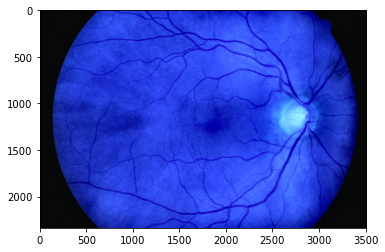

In [4]:
# apply contrast limited adaptive histogram equalization to the L channel
# https://stackoverflow.com/questions/24341114/simple-illumination-correction-in-images-opencv-c
clahe = cv.createCLAHE(clipLimit=3.0)
merged = cv.merge((clahe.apply(l), a, b))
merged = cv.cvtColor(merged, cv.COLOR_LAB2BGR)
# imshow(clahe.apply(l))
imshow(merged)


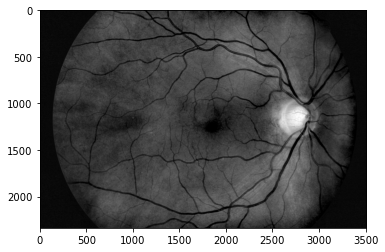

In [5]:
# convert image to BGR and extract green channel (vessels' visibility is the best)
b, g, r = cv.split(merged)

imshow(g, cmap='gray')


In [6]:
from skimage.util import img_as_bool
from skimage.morphology import binary_erosion, remove_small_objects, remove_small_holes
image_frangi = frangi(g)



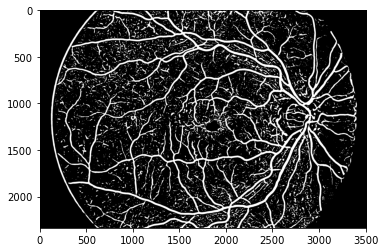

In [7]:
ret, thresh = cv.threshold(image_frangi, np.mean(
    image_frangi)*0.45, 255, cv.THRESH_BINARY)#for healthy eyes *0.4 bc of thin tips
thresh = thresh.astype('uint8')
imshow(thresh, cmap='gray')


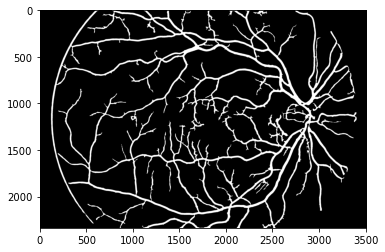

In [8]:
deblobed = thresh > 0
deblobed = remove_small_objects(deblobed, 2500, connectivity=2)
deblobed = remove_small_holes(deblobed, 900, connectivity=1)
deblobed = deblobed.astype('uint8')*255
# (6,6) gives ca 96-98% accuracy and specificity
deblobed = cv.erode(
    deblobed, cv.getStructuringElement(cv.MORPH_ELLIPSE, (1, 1)))
deblobed = cv.morphologyEx(deblobed, cv.MORPH_CLOSE,
                           cv.getStructuringElement(cv.MORPH_ELLIPSE, (12, 12)))
imshow(deblobed, cmap='gray')


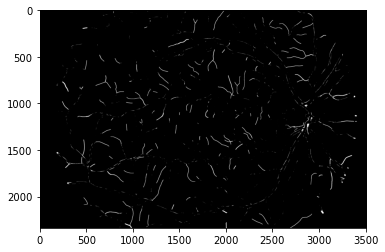

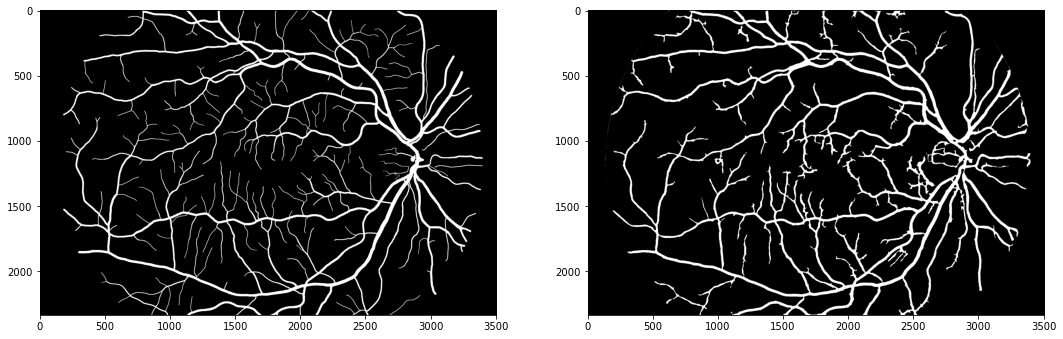

In [9]:
from matplotlib import pyplot as plt
# load the hand-made mask
mask = cv.imread('data/all/manual1/07_h.tif', cv.IMREAD_GRAYSCALE)
cut = cv.imread('data/all/mask/07_h_mask.tif', cv.IMREAD_GRAYSCALE)
cut = cv.bitwise_and(cut, deblobed)
# imshow(mask, cmap='gray')
diff = (mask - cut)
imshow(diff, cmap='gray')

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(18, 12)
ax1.imshow(mask, cmap='gray')
ax2.imshow(cut, cmap='gray')


TN 7189716
FP 266615
FN 101492
TP 627521


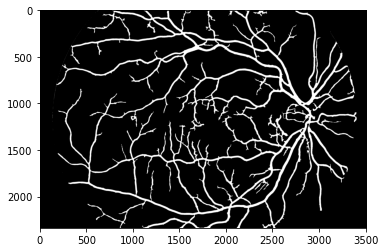

In [10]:
from sklearn.metrics import confusion_matrix
processed = cut
imshow(cut, cmap='gray')

image_size = processed.shape[0]*processed.shape[1]

mask_binary = mask.copy()
mask_binary[mask_binary < 127] = 0
mask_binary[mask_binary >= 127] = 1

processed_binary = processed.copy()
processed_binary[processed_binary < 127] = 0
processed_binary[processed_binary >= 127] = 1

#TN, FP, FN, TP = confusion_matrix(mask_binary.flatten(), processed_binary.flatten()).ravel()
TP = np.sum(processed_binary[mask_binary == 1])
FP = np.sum(processed_binary[mask_binary == 0])
FN = np.sum(mask_binary[mask_binary == 1]) - \
    np.sum(processed_binary[mask_binary == 1])
TN = image_size - np.sum(processed_binary[mask_binary == 0]) - TP - FN
print(f'TN', TN)
print(f'FP', FP)
print(f'FN', FN)
print(f'TP', TP)
#print(FN + FP + TP + TN - image_size)


In [11]:
accuracy = (TP + TN) / (TP + FP + FN + TN)
sensitivity = TP / (TP + FN)
specificity = TN / (TN + FP)
print(f'accuracy:', accuracy)
print(f'sensitivity : ', sensitivity)
print(f'specificity: ', specificity)


accuracy: 0.9550285241524363
sensitivity :  0.8607816321519643
specificity:  0.9642431378113445


In [5]:
from process_image import process_image
import cv2 as cv

accuracies = []
sensitivities = []
specificities = []

for i in range(1, 16):
    image = cv.imread('data/all/images/' + str(i).zfill(2) + '_h.JPG')
    manual = cv.imread('data/all/manual1/' + str(i).zfill(2) +
                       '_h.tif', cv.IMREAD_GRAYSCALE)
    mask = cv.imread('data/all/mask/' + str(i).zfill(2) +
                     '_h_mask.tif', cv.IMREAD_GRAYSCALE)
    TN, FP, FN, TP = process_image(image, manual, mask)

    accuracy = (TP + TN) / (TP + FP + FN + TN)
    sensitivity = TP / (TP + FN)
    specificity = TN / (TN + FP)
    accuracies.append(accuracy)
    sensitivities.append(sensitivity)
    specificities.append(specificity)


    


In [52]:
geometric_means = []
geometric_means = np.sqrt(np.multiply(specificities, sensitivity))
from ipyregulartable import RegularTableWidget as table
import numpy as np
import pandas as pd
data = [accuracies, sensitivities, specificities, geometric_means]
data = pd.DataFrame(data, index=['accuracy', 'sensitivity', 'specificity', 'G-mean']).transpose()
data.loc['mean values'] = data.mean()
dt = table(data)
display(dt)

RegularTableWidget()